# CS6140 - Machine Learning: Assignment 4 
(Total Points: 100)
## Prof. Ahmad Uzair 

# Q1. Expectation Maximization (25 Points)

Etimate the probability distribution in a 1-dimensional dataset
There are two Normal distributions  𝑁(𝜇1,𝜎1^2) and 𝑁(𝜇2,𝜎2^2).

There are 5 paramaters to estimate: $𝜃=(𝑤, 𝜇1, 𝜎_1^2, 𝜇2,𝜎_2^2)$ where 𝑤 is the probability that the data comes from the first normal probability distribution and (1-𝑤) comes from the second normal probability distribution.

The probability density function (PDF) of the mixture model is: $𝑓(𝑥|𝜃)=𝑤 𝑓1(𝑥 | 𝜇1,𝜎_1^2)+(1−𝑤) 𝑓2(𝑥 | 𝜇2,𝜎_2^2)$
Your goal is to best fit a given probability density by finding $𝜃=(𝑤,𝜇1,𝜎_1^2,𝜇2,𝜎_2^2)$ through EM iterations.

Using the following way to produce data:

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas
import time

In [2]:
random_seed=36788765
np.random.seed(random_seed)

Mean1 = 2.0  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4.0 #@param {type:"number"}
Mean2 = 9.0 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2.0 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

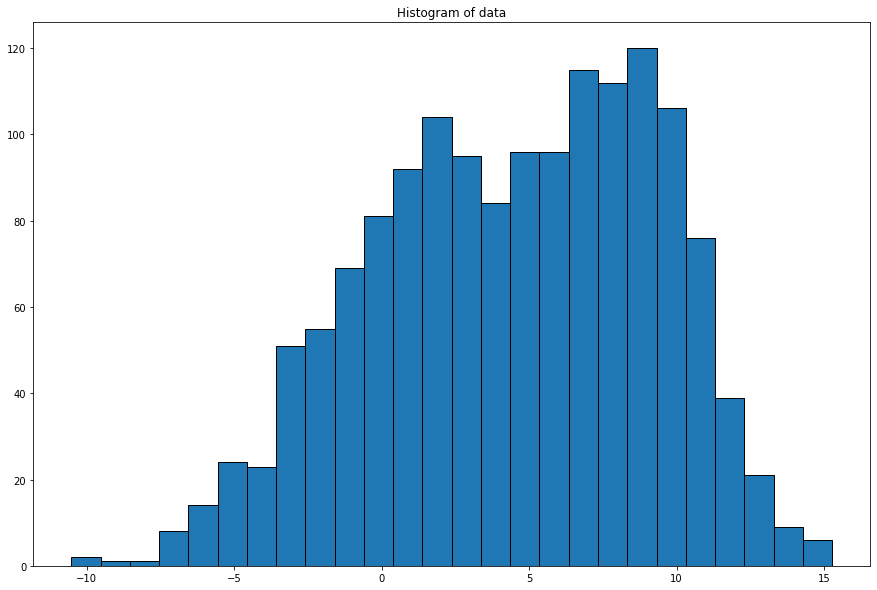

In [3]:
# Plotting a histogram of the data
plt.figure(figsize=(15, 10))
plt.hist(data, bins = 26, edgecolor="black")
plt.title("Histogram of data")
plt.show()

(1) Using a single Gaussion to estimate and create a plot to see the result: (10 points)


In [4]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, x):
        "Probability of a data point given the current parameters"
        return 1/(self.sigma*np.sqrt(2*np.pi))*np.exp(-(1/2)*((x-self.mu)/self.sigma)**2)

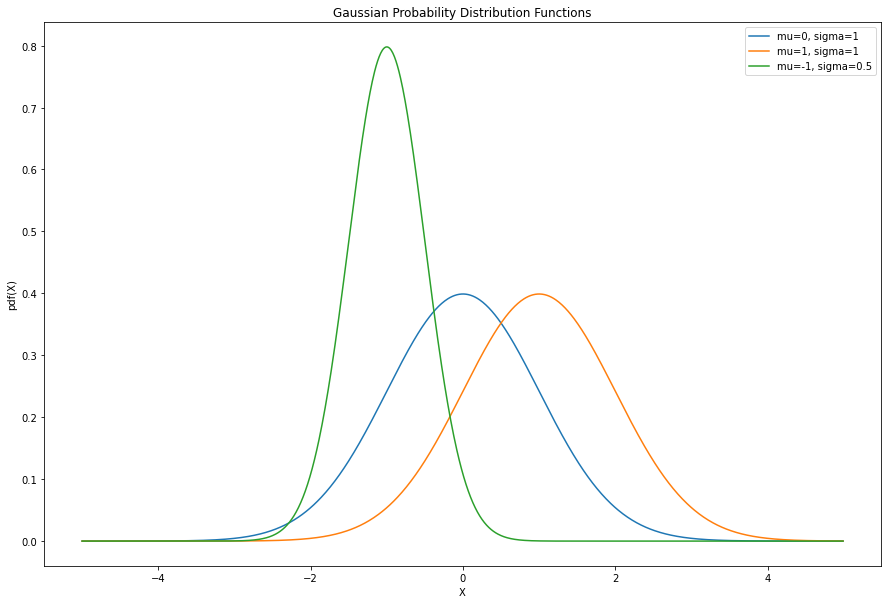

In [5]:
x = [0.01 * i for i in range(-500,500)]
y1 = [Gaussian(0,1).pdf(i) for i in x]
y2 = [Gaussian(1,1).pdf(i) for i in x]
y3 = [Gaussian(-1,0.5).pdf(i) for i in x]

plt.figure(figsize=(15, 10))
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.legend(['mu=0, sigma=1', 'mu=1, sigma=1','mu=-1, sigma=0.5'])
plt.title("Gaussian Probability Distribution Functions")
plt.xlabel('X')
plt.ylabel('pdf(X)')
plt.show()

(2) Using a 2 Gaussian mixture model to estimate and create a plot to see the result(Do not use sklearn GaussianMixture): (15 points)


In [6]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"
    
    #Initialization of the Gaussian Mixture Model
    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1.0, sigma_max=1.0, mix=.5):
        """
        Initializes the Gaussian Mixture Model
        :param data: Data of the model
        :param mu_min: Initial mean of 1st Gaussian Distribution
        :param mu_max: Initial mean of 2nd Gaussian Distribution
        :param sigma_min: Initial sigma of 1st Gaussian Distribution
        :param sigma_max: Initial sigma of 2nd Gaussian Distribution
        :param mix: Initial probability of 1st Gaussian Distribution
        """
        self.k = 2
        self.n = np.shape(data)[0]
        self.data = data
        self.z = 0.5*np.ones((self.n,self.k))
        self.mu = np.array([mu_min, mu_max])
        self.sigma = np.array([sigma_min, sigma_max])
        self.prob = np.array([mix, 1-mix])

    def Estep(self):
        '''
        E-Step to update gamma(z) values
        '''
        for i in range(self.n):
            for j in range(self.k):
                self.z[i][j] = (self.prob[j] * self.gaussianPDF(self.data[i], self.mu[j], self.sigma[j]))/self.pdf(self.data[i])

    def Mstep(self):
        """
        M-Step to update the parameters: mu1, mu2, sigma1, sigma2, prob1, prob2
        """
        for j in range(self.k):
            # Updating probs
            temp_num = 0.0
            for i in range(self.n):
                temp_num += self.z[i][j]
            self.prob[j] = temp_num/self.n
            
            # Updating mu
            temp_mu = 0.0
            for i in range(self.n):
                temp_mu+= self.z[i][j]*self.data[i]
            self.mu[j] = temp_mu/temp_num
            
            # Updating sigma
            temp_var = 0.0
            for i in range(self.n):
                temp_var+= self.z[i][j]*((self.data[i]-self.mu[j])**2)
            self.sigma[j] = np.sqrt(temp_var/temp_num)
            
    def iterate(self, N=1, verbose=False):
        """
        Iterating to learn the model parameters and update the log likelihood
        :param N: Number of iterations
        :param verbose: To display the progress
        :returns: Log Likelihoods after each iterations
        """
        log_likelihood = np.zeros(N)
        for i in range(N):
            if verbose:
                print(f"Iteration: {i}")
            self.Estep()
            self.Mstep()
            log_likelihood[i] = self.log_likelihood()
        return log_likelihood
    
    def log_likelihood(self):
        """
        Calculates the current log-likelihood
        """
        ans = 0.0
        for i in range(self.n):
            curr_val = 0
            for j in range(self.k):
                curr_val += self.prob[j]*self.gaussianPDF(self.data[i], self.mu[j], self.sigma[j])
            ans+= np.log(curr_val)
        return ans

    def pdf(self, x):
        """
        Calculating combined pdf of the model for input X
        :param x: input value
        :return: pdf(x) pased on the model
        """
        val = 0.0
        for j in range(self.k):
            val+=self.prob[j]*self.gaussianPDF(x, self.mu[j], self.sigma[j])
        return val
    
    # Gaussian pdf 
    def gaussianPDF(self, x, mu, sigma):
        """
        Calculating gaussian univariate pdf for input X, mean mu and standard deviation sigma.
        :param x: input value
        :param mu: Mean of the gaussian distribution
        :param sigma: Standard deviation of the gaussian distribution
        :return: gaussian pdf(x|mu, sigma)
        """
        return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(1/2)*((x-mu)/sigma)**2)


In [7]:
# Creating a Gaussian Mixture Model and Fitting it for given data
N = 200
gaussian_mixture = GaussianMixture(data)
likelihood = gaussian_mixture.iterate(N=N, verbose=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [8]:
#Printing the Individual Gaussian Models learned
print(f"Estimated Gaussian Distribution-1:")
print(f"Mean = {gaussian_mixture.mu[0]}")
print(f"Std Dev = {gaussian_mixture.sigma[0]}")
print(f"Probability = {gaussian_mixture.prob[0]}")
print()
print(f"Estimated Gaussian Distribution-2:")
print(f"Mean = {gaussian_mixture.mu[1]}")
print(f"Std Dev = {gaussian_mixture.sigma[1]}")
print(f"Probability = {gaussian_mixture.prob[1]}")

Estimated Gaussian Distribution-1:
Mean = 1.7642381123950073
Std Dev = 3.818840190918974
Probability = 0.618404946894056

Estimated Gaussian Distribution-2:
Mean = 8.80195296944504
Std Dev = 2.209429305522029
Probability = 0.3815950531059441


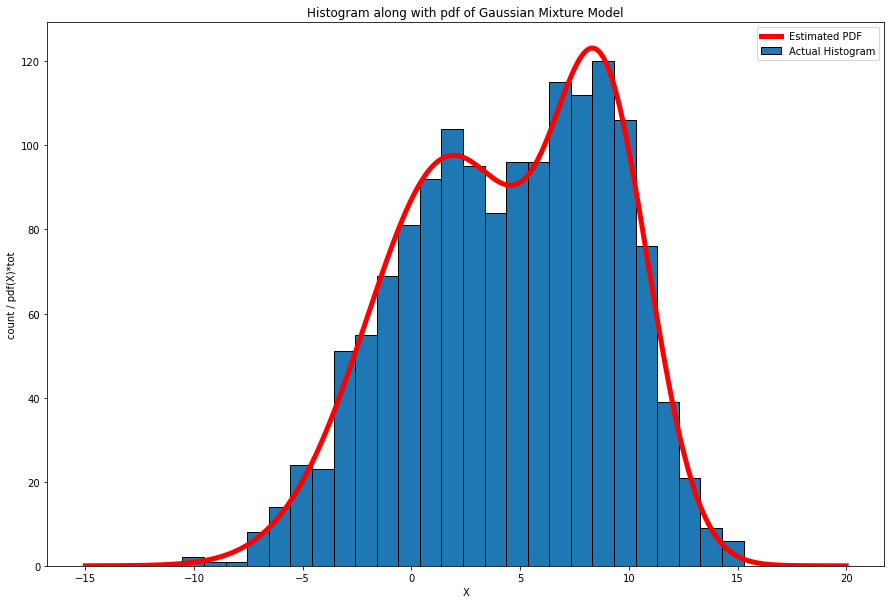

In [9]:
#Plotting the Histogram along with the PDF of the model.

plt.figure(figsize=(15, 10))
plt.hist(data, bins = 26, edgecolor='black')
x = [0.01 * i for i in range(-1500,2000)]
y = [gaussian_mixture.pdf(i)*gaussian_mixture.n for i in x]
plt.plot(x,y,c='red',linewidth=5)
plt.title("Histogram along with pdf of Gaussian Mixture Model")
plt.xlabel('X')
plt.ylabel('count / pdf(X)*tot')
plt.legend(["Estimated PDF","Actual Histogram"])
plt.show()

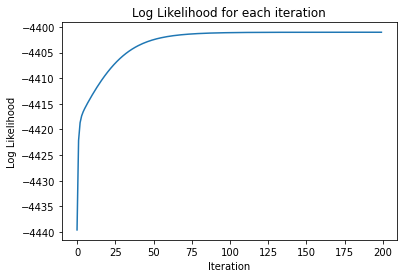

In [10]:
x = [i for i in range(N)]
plt.plot(x,likelihood)
plt.title("Log Likelihood for each iteration")
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()

# Q2. (65 Points)
Comparison for Logistic Regression model: before and after PCA.
Consider dataset.csv.
Please follow the following steps:

  1. Standardize the disease classification dataset (dataset.csv). You can use StandardScaler of sklearn. (5 points)
  2. Split the data in 80-20 train-val sets. Apply Eigen-decomposition using PCA **only** on train set. You can use externel libaries such as numpy (Ref np.linalg.eig) (10 points)
  3. Selection first 6 component loadings with the highest variance-explanation) (10 points)
  4. Project train set in the new 6-dimensional feature space using eigen vectors selected in step 3. (10 points)
  5. Train two logistic regression models. One for the standardized (all features) and second for the transformed data (6-features). Report train-sets (standardized and transformed) ROC curves for both models. (10 Points)
  6. Validate the model using val set. Project val set in the new 6-dimensional feature space using eigen vectors selected in step 3. Predict target variable using the models trained in step 5. (10 Points)
  7. Compare the logistic regression models before and after PCA using ROC curve. (5 points)

In [47]:
#Imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.linear_model as sklearnmodel

In [12]:
#Loading Data
data = pandas.read_csv("data/dataset.csv")
X = data.drop("class", axis=1).drop("id", axis=1).values
Y = data["class"].values
print(X)
print(np.shape(X))

[[ 1.       0.85247  0.71826 ...  2.6202   3.0004  18.9405 ]
 [ 1.       0.76686  0.69481 ...  6.5245   6.3431  45.178  ]
 [ 1.       0.85083  0.67604 ...  2.9199   3.1495   4.7666 ]
 ...
 [ 0.       0.88389  0.72335 ...  3.5377   3.3545   5.0424 ]
 [ 0.       0.83782  0.7489  ...  2.6801   2.8332   3.7131 ]
 [ 0.       0.81304  0.76471 ...  4.0116   2.6217   3.1527 ]]
(756, 753)


In [13]:
# Step-1: Standardizing the dataset using StandardScaler of sklearn
scaler = StandardScaler()
scaler.fit(X)
X_scaler = scaler.transform(X)
print(X_scaler)

[[ 0.96874225  0.62764391  0.2561442  ... -0.775137   -0.81472704
  -0.36659507]
 [ 0.96874225  0.12161952 -0.08043329 ... -0.52664699 -0.58297219
   0.40039616]
 [ 0.96874225  0.61795018 -0.34983882 ... -0.75606253 -0.8043897
  -0.7809355 ]
 ...
 [-1.03226633  0.81336154  0.3292009  ... -0.71674252 -0.79017671
  -0.77287314]
 [-1.03226633  0.54105055  0.69591966 ... -0.77132466 -0.82631929
  -0.81173208]
 [-1.03226633  0.3945807   0.92284035 ... -0.68658105 -0.84098293
  -0.82811405]]


In [14]:
# Step-2.1: Splitting Data into 80-20 Train-Val Sets
X_train, X_val, Y_train, Y_val = train_test_split(X_scaler, Y, test_size=0.20)

In [15]:
#Function to get eigen_values and eigen_vectors using np.linalg.eig
def get_eigen_values_vectors(X):
    cov = np.cov(X)
    eigen_values, eigen_vectors = np.linalg.eig(cov)
    eigen_values = eigen_values.real
    eigen_vectors = eigen_vectors.real
    return (eigen_values, eigen_vectors)

#Function to get explained variances from eigen_values
def get_explained_variances(eigen_values):
    explained_variances = []
    tot_explained_variances = []
    tot=0.0
    for i in range(len(eigen_values)):
        val = eigen_values[i]/np.sum(eigen_values)
        tot+=val
        explained_variances.append(val)
        tot_explained_variances.append(tot)
    return explained_variances, tot_explained_variances

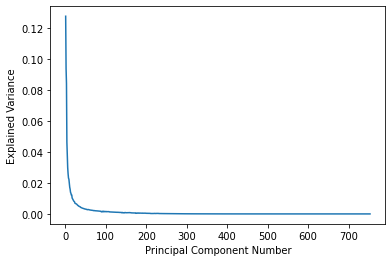

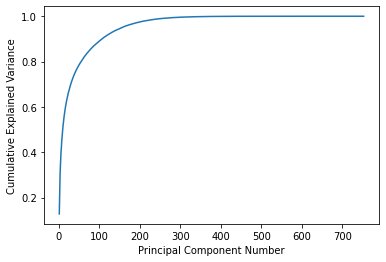

In [16]:
#Step2.2: Eigen-decomposition using PCA on train set
eigen_values, eigen_vectors = get_eigen_values_vectors(X=X_train.T)
x = [i+1 for i in range(len(eigen_values))]
explained_variances, tot_explained_variances = get_explained_variances(eigen_values)

plt.plot(x, explained_variances)
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance")
plt.show()

plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Explained Variance")
plt.plot(x, tot_explained_variances)
plt.show()

In [17]:
#Step-3: Selecting First 6 components (Eigen Values and Vectors) with highest variance-explanations
k = 6
best_eigen_vectors = eigen_vectors[:, :k]
best_eigen_values = eigen_values[:k]

print(f"Cumulative Explained Variance of first {k} components: {tot_explained_variances[k-1]}")

Cumulative Explained Variance of first 6 components: 0.42101766913112


In [18]:
#Step-4: Projecting training sets into 6-dimensional feature space using best_eig_vectors

#Function to convert X into PCA using eigen_vectors
def convert_principle_component(X, eigen_vectors):
    return np.dot(X, eigen_vectors)

PC_train = convert_principle_component(X_train, best_eigen_vectors)
print(np.shape(PC_train))
print(PC_train)

(604, 6)
[[ -1.22206918  11.98178057   2.28632722  -4.98299267  -0.2892362
    1.83703074]
 [-16.96482634  15.98506333   0.62221538 -11.91636646   1.07806767
   15.70719767]
 [  7.02216256  -4.35868554   4.9023036   -3.23329191   1.28070165
   -4.908935  ]
 ...
 [ 12.07078314 -18.38632281   3.53760029  -4.20679012   4.41025441
    0.26380556]
 [  1.80774488  11.65162714  -4.87968494   6.23401857  -2.19037944
    1.21183837]
 [ 11.73527736   3.25917405  -3.8880533   -2.82098099  -6.47486223
    9.82304911]]


In [19]:
# Class for Logistic Regression
class LogisticRegression:

    def __init__(self):
        self.params = None
        return

    def sigmoid(self, z):
        """
        Returns sigmoid of z
        :param z: input
        :return: sigmoid of z
        """
        return 1.0 / (1.0 + np.exp(-z))

    def compute_cost(self, ip, op):
        """
        Log loss cost function in linear regression where the cost is calculated
        ip: input variables
        op: output variables
        params: corresponding parameters
        Returns cost
        """
        num_samples = len(ip)
        cost_sum = 0.0
        for x, y in zip(ip, op):
            y_hat = self.sigmoid(np.dot(self.params, x))
            cost_sum = cost_sum - ((y * np.log(y_hat)) + ((1 - y) * (np.log(1 - y_hat))))

        cost = cost_sum / num_samples

        return cost

    def batchify(self, ip, op, batch_size):
        """
        Converts the given data into batches of batch_size. Last batch can contain data of smaller size
        :param ip: Features
        :param op: Labels
        :param batch_size: Size of each bach
        :return: the features and labels converted into batches
        """
        X_Batch = []
        Y_Batch = []

        for i in range(int(np.ceil(len(ip) / batch_size))):
            X_Batch.append([])
            Y_Batch.append([])
        for i in range(len(ip)):
            X_Batch[int(i / batch_size)].append(ip[i])
            Y_Batch[int(i / batch_size)].append(op[i])
        num_batches = len(X_Batch)
        return X_Batch, Y_Batch, num_batches

    def batchGradientDescent(self, ip, op, paramss, alpha, max_iter, batch_size=1):
        """
        Compute the params for logistic regression using batch gradient descent
        ip: input variables
        op: output variables
        params: corresponding parameters
        alpha: learning rate
        max_iter: maximum number of iterations
        Returns parameters, cost
        """
        # initialize iteration, number of samples, cost and parameter array
        iteration = 0
        num_samples = len(ip)
        num_params = len(paramss)
        self.params = paramss

        # batchify the data into mini-batches
        X_Batch, Y_Batch, num_batches = self.batchify(ip, op, batch_size)
        cost = np.zeros(max_iter)

        # Compute the cost and store the params for the corresponding cost
        while iteration < max_iter:
            cost[iteration] = self.compute_cost(ip, op)
            
            print(f'iteration: {iteration}')

            # Apply batch gradient descent
            for k in range(num_batches):

                batch_length = len(X_Batch[k])
                partialDifferentials = np.zeros(num_params)
                for i in range(batch_length):
                    sgm = self.sigmoid(np.dot(self.params, X_Batch[k][i]))
                    for j in range(num_params):
                        partialDifferentials[j] += (sgm - Y_Batch[k][i]) * X_Batch[k][i][j]
                self.params = self.params - (alpha / batch_length * partialDifferentials)
            iteration += 1

        return self.params

    def predictOne(self, x, threshold):
        """
        Predicts the label of a single input x based on trained model
        :param x: Features of an input
        :return: Corresponding predicted label
        """
        sgm = self.sigmoid(np.dot(self.params, x))
        if sgm >= threshold:
            return 1
        else:
            return 0

    def predict(self, x, threshold):
        """
        Predicts the label of multiple inputs.
        :param x: Feature vector for a list of inputs
        :return: Corresponding predicted labels
        """
        y_cap = [self.predictOne(x[i], threshold) for i in range(len(x))]
        return y_cap

    def calc_accuracy(self, y_hat, y):
        """
        Accuracy of the model
        :param y_hat: predicted labels
        :param y: actual labels
        :return: Accuracy
        """
        count = 0
        for i in range(len(y)):
            if y_hat[i] == y[i]:
                count += 1
        return count / len(y)

    def evaluate(self, x, y, threshold=0.5, verbose = False):
        """
        Calculates various statistical measures of the model
        :param x: Features of n inputs
        :param y: Corresponding labels
        :return: Prints the different measures of the model
        """
        TP, FP, TN, FN = 0, 0, 0, 0
        for i in range(len(x)):
            y_cap = self.predictOne(x[i], threshold)
            if y[i] == 1 and y_cap == 1:
                TP += 1
            elif y[i] == 1 and y_cap == 0:
                FN += 1
            elif y[i] == 0 and y_cap == 0:
                TN += 1
            elif y[i] == 0 and y_cap == 1:
                FP += 1
        if verbose:
            print(f"True Positive: {TP}")
            print(f"False Positive: {FP}")
            print(f"True Negative: {TN}")
            print(f"False Negative: {FN}")
            print(f"Accuracy: {(TP+TN)/(TP+FP+TN+FN)}")
            if TP+FP == 0:
                print("Precision cannot be calculated as TP+FP = 0")
            else:
                print(f"Precision: {TP/(TP+FP)}")
            if TP+FN == 0:
                print("Recall cannot be calculated as TP+FN = 0")
            else:
                print(f"Recall: {(TP/(TP+FN))}")
        return TP, FP, TN, FN

In [20]:
#Step-5.1: Training Logistic Regression Model on Standardized data
intitial_params = np.ones(X_train.shape[1])
learning_rate = 0.01
max_iter = 1000
batch_size = 64

logisticRegressionRaw = LogisticRegression()
start_time = time.time()
logisticRegressionRaw.batchGradientDescent(X_train, Y_train, intitial_params, learning_rate,max_iter, batch_size)
print(f"Total time taken: {time.time() - start_time} seconds")

iteration: 0


C:\Users\patel\AppData\Local\Temp\ipykernel_28384\610868089.py:28: RuntimeWarning: divide by zero encountered in log
  cost_sum = cost_sum - ((y * np.log(y_hat)) + ((1 - y) * (np.log(1 - y_hat))))
C:\Users\patel\AppData\Local\Temp\ipykernel_28384\610868089.py:28: RuntimeWarning: invalid value encountered in multiply
  cost_sum = cost_sum - ((y * np.log(y_hat)) + ((1 - y) * (np.log(1 - y_hat))))


iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

iteration: 558
iteration: 559
iteration: 560
iteration: 561
iteration: 562
iteration: 563
iteration: 564
iteration: 565
iteration: 566
iteration: 567
iteration: 568
iteration: 569
iteration: 570
iteration: 571
iteration: 572
iteration: 573
iteration: 574
iteration: 575
iteration: 576
iteration: 577
iteration: 578
iteration: 579
iteration: 580
iteration: 581
iteration: 582
iteration: 583
iteration: 584
iteration: 585
iteration: 586
iteration: 587
iteration: 588
iteration: 589
iteration: 590
iteration: 591
iteration: 592
iteration: 593
iteration: 594
iteration: 595
iteration: 596
iteration: 597
iteration: 598
iteration: 599
iteration: 600
iteration: 601
iteration: 602
iteration: 603
iteration: 604
iteration: 605
iteration: 606
iteration: 607
iteration: 608
iteration: 609
iteration: 610
iteration: 611
iteration: 612
iteration: 613
iteration: 614
iteration: 615
iteration: 616
iteration: 617
iteration: 618
iteration: 619
iteration: 620
iteration: 621
iteration: 622
iteration: 623
iteration:

In [21]:
#Step-5.2: Training Logistic Regression Model on Transformed data with 6 features
intitial_params = np.ones(PC_train.shape[1])
learning_rate = 0.01
max_iter = 1000
batch_size = 64

logisticRegressionTransformed = LogisticRegression()
start_time = time.time()
logisticRegressionTransformed.batchGradientDescent(PC_train, Y_train, intitial_params, learning_rate,max_iter, batch_size)
print(f"Total time taken: {time.time() - start_time} seconds")

C:\Users\patel\AppData\Local\Temp\ipykernel_28384\610868089.py:28: RuntimeWarning: divide by zero encountered in log
  cost_sum = cost_sum - ((y * np.log(y_hat)) + ((1 - y) * (np.log(1 - y_hat))))
C:\Users\patel\AppData\Local\Temp\ipykernel_28384\610868089.py:28: RuntimeWarning: invalid value encountered in multiply
  cost_sum = cost_sum - ((y * np.log(y_hat)) + ((1 - y) * (np.log(1 - y_hat))))


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

iteration: 577
iteration: 578
iteration: 579
iteration: 580
iteration: 581
iteration: 582
iteration: 583
iteration: 584
iteration: 585
iteration: 586
iteration: 587
iteration: 588
iteration: 589
iteration: 590
iteration: 591
iteration: 592
iteration: 593
iteration: 594
iteration: 595
iteration: 596
iteration: 597
iteration: 598
iteration: 599
iteration: 600
iteration: 601
iteration: 602
iteration: 603
iteration: 604
iteration: 605
iteration: 606
iteration: 607
iteration: 608
iteration: 609
iteration: 610
iteration: 611
iteration: 612
iteration: 613
iteration: 614
iteration: 615
iteration: 616
iteration: 617
iteration: 618
iteration: 619
iteration: 620
iteration: 621
iteration: 622
iteration: 623
iteration: 624
iteration: 625
iteration: 626
iteration: 627
iteration: 628
iteration: 629
iteration: 630
iteration: 631
iteration: 632
iteration: 633
iteration: 634
iteration: 635
iteration: 636
iteration: 637
iteration: 638
iteration: 639
iteration: 640
iteration: 641
iteration: 642
iteration:

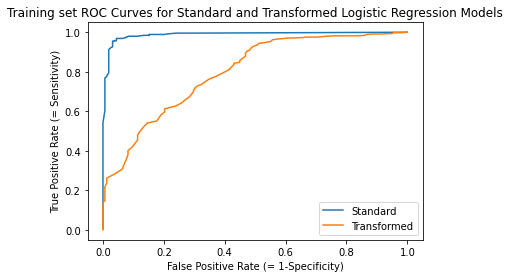

In [22]:
#Step-5.3: Training set ROC curves for both models:
thresholds = [0.01*(i) for i in range(101)]
tprRaw = []
fprRaw = []
tprTransformed = []
fprTransformed = []

for t in thresholds:
    TP, FP, TN, FN = logisticRegressionRaw.evaluate(X_train, Y_train, t)
    tprRaw.append(TP/(TP+FN))
    fprRaw.append(FP/(FP+TN))
    TP, FP, TN, FN = logisticRegressionTransformed.evaluate(PC_train, Y_train, t)
    tprTransformed.append(TP/(TP+FN))
    fprTransformed.append(FP/(FP+TN))

plt.plot(fprRaw, tprRaw)
plt.plot(fprTransformed, tprTransformed)
plt.title("Training set ROC Curves for Standard and Transformed Logistic Regression Models")
plt.xlabel("False Positive Rate (= 1-Specificity)")
plt.ylabel("True Positive Rate (= Sensitivity)")
plt.legend(["Standard", "Transformed"])
plt.show()

In [23]:
# Step-6.1: Projecting validation set in the new 6-dimensional feature space using selected eigen vectors
PC_val = convert_principle_component(X_val, best_eigen_vectors)
print(np.shape(PC_val))
print(PC_val)

(152, 6)
[[ 8.61382500e+00  2.10021787e+00  6.85156297e-01  1.16159652e+01
   1.58212204e+00  3.89150637e+00]
 [ 4.34242278e+00 -9.96600236e+00  2.37412790e+00  2.27556467e-01
   1.76435917e+00 -2.65399108e-01]
 [-1.06775875e+01 -3.07109451e+00  3.18932397e+00  2.10546043e+00
   7.90617057e-01 -5.24978596e-01]
 [ 6.39603029e+00  4.61667690e+00  1.92297682e+00 -1.51899261e+00
  -1.46476233e+00 -1.73747151e+00]
 [ 1.83581766e+01 -2.16170177e+00 -1.92855909e+00 -6.54856980e+00
   7.34056655e+00 -2.69425693e+00]
 [-3.71886500e+00 -2.36566344e+00  1.59096575e+00  8.13972675e+00
   1.99180101e+00  4.04650844e+00]
 [-1.68580207e+01  7.95553644e-01  4.23509784e+00 -1.68581846e+00
  -2.65167676e+00  1.15749595e+00]
 [ 1.01136579e+01  1.51991082e-02 -5.39903804e-01  1.09067313e+01
   1.51317547e+00  3.92991452e+00]
 [ 1.09561900e+01  1.31348081e+00  1.31780658e+00  5.71116594e-01
   1.77672765e+00 -1.40734309e+00]
 [-2.85595174e+00  6.32214809e+00  1.06896388e+00 -4.39637161e+00
   3.04648692e+0

In [24]:
#Step-6.2: Predicting target variable using the models trained and reporing the performance measures
print("Performance Measures using Standardized Logistic Regression Model on Validation Set")
logisticRegressionRaw.evaluate(X_val, Y_val, verbose=True)
print()

print("Performance Measures using Transformed Logistic Regression Model on Validation Set")
logisticRegressionTransformed.evaluate(PC_val, Y_val, verbose=True)
print()

Performance Measures using Standardized Logistic Regression Model on Validation Set
True Positive: 78
False Positive: 8
True Negative: 26
False Negative: 40
Accuracy: 0.6842105263157895
Precision: 0.9069767441860465
Recall: 0.6610169491525424

Performance Measures using Transformed Logistic Regression Model on Validation Set
True Positive: 80
False Positive: 8
True Negative: 26
False Negative: 38
Accuracy: 0.6973684210526315
Precision: 0.9090909090909091
Recall: 0.6779661016949152



### Step-7: Compare the logistic regression models before and after PCA using ROC curve.
- From the given ROC curves, it can be seen that area under the ROC curve for Standard Logistic Regression Model is more than the Transformed Logistic Regression Model. This means that Standard Logistic Regression Model performs better with Training dataset.

- However using the performance measures on validation dataset, it can be seen that both models give comparable performances under validation set.

- The cumulative explained variance for Principal Components came as 42%.

- The actual advantage of Transformed Model is the time taken to train the model. The Standard Model took 200 seconds to train whereas the Transformed model took only 8 seconds to train.

# Q3. (10 Points)
Outlier Detection using Z-score. (10 points)
You are given a Heights and Weights Dataset and a threshold 1. Calculate the number of outliar and show the first 5 of them.


In [25]:
# Reading the data of heights and weights
data = pandas.read_csv("data/HeightWeight.csv").drop("Index", axis=1)
columns = data.columns
X = data.values

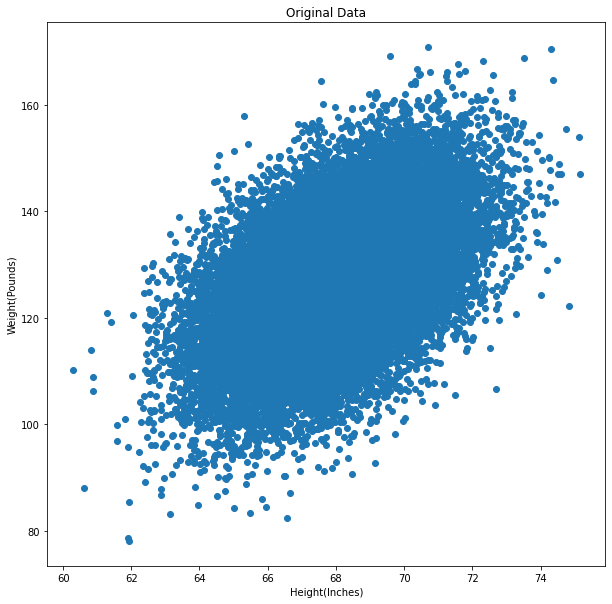

In [26]:
# Plotting the Data Points
plt.figure(figsize=(10, 10))
plt.title("Original Data")
plt.scatter(X[:,0], X[:,1])
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

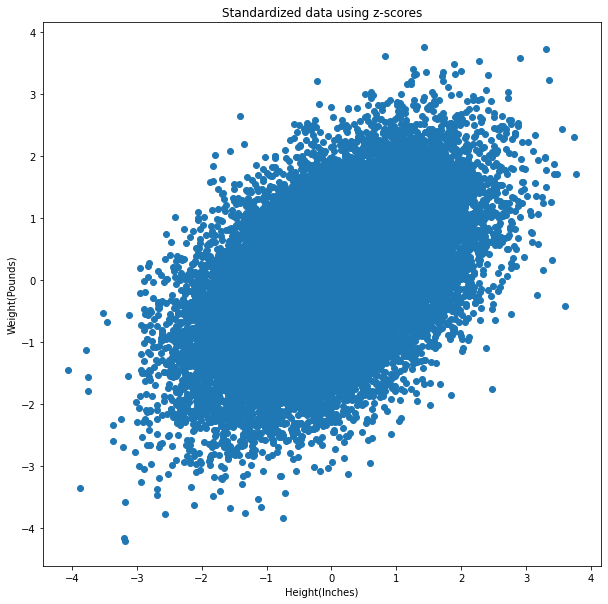

In [27]:
# Standardizing using Z-scores and plotting the data again
data_mean = np.mean(X, axis=0)
data_std = np.std(X, axis=0)
data_z = (X-data_mean)/data_std
data_all = pandas.DataFrame(data)
data_all["Height_z"] = data_z[:,0]
data_all["Weight_z"] = data_z[:,1]
colors = {True:'red', False:'green'}

plt.figure(figsize=(10, 10))
plt.title("Standardized data using z-scores")
plt.scatter(data_z[:,0], data_z[:,1])
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [28]:
# Univariate analysis using t-scores. Since data is very large, using z-scores instead
# from scipy.stats import t
# alpha = 0.95
# N = data.shape[0]
# print(N)
# t_val = t.ppf(1 - alpha / (2 * N), N - 2)
# grubs_threshold = ((N-1)/np.sqrt(N)) * (np.sqrt(t_val**2 / ((N-2 + t_val**2))))
# grubs_threshold

# data_z_df['Height_grub'] = data_z_df['Height_z'].abs() >= grubs_threshold
# data_z_df['Weight_grub'] = data_z_df['Weight_z'].abs() >= grubs_threshold
# data_z_df

# plt.figure(figsize=(30, 3))
# fig, ax = plt.subplots(2, sharex=True)
# fig.set_figheight(15)
# fig.set_figwidth(20)
# ax[0].scatter(x=range(N), y=data_z_df["Height_z"], c=data_z_df["Height_grub"].map(colors))
# ax[0].set_ylabel('Height Z Score')
# ax[1].scatter(x=range(N), y=data_z_df["Weight_z"], c=data_z_df["Weight_grub"].map(colors))
# ax[1].set_ylabel('Weight Z score')

# plt.show()

# plt.scatter(data_z[:, 0], data_z[:,1], c=data_z_df["Weight_grub"].map(colors))
# plt.show()

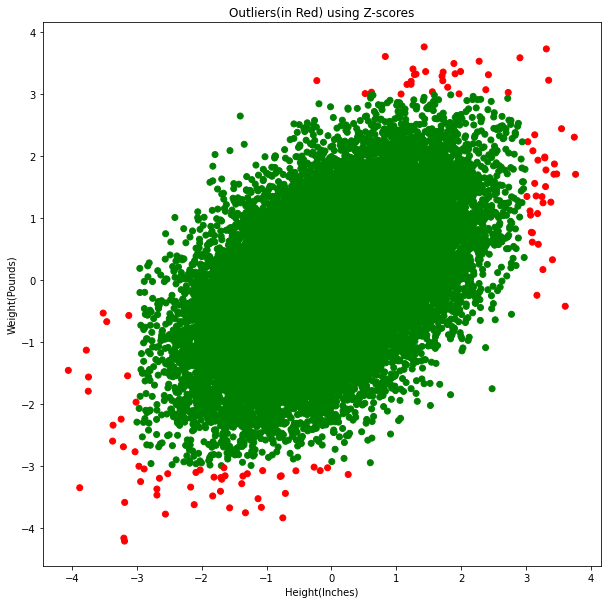

In [29]:
# Setting the threshold of 3 instead of 1 as 1 contained a lot of outliers. 
threshold = 3
data_all['Height_z_outlier'] = data_all['Height_z'].abs() > threshold
data_all['Weight_z_outlier'] = data_all['Weight_z'].abs() > threshold

# Setting the data point as outlier if either of the Height or Weight is an outlier
Z_score_outlier = []
for i, d in data_all.iterrows():
    Z_score_outlier.append(d['Height_z_outlier'] or d['Weight_z_outlier'])
data_all['Z_score_outlier'] = Z_score_outlier

#Plotting the Z-scores with outliers

plt.figure(figsize=(10, 10))
plt.title("Outliers(in Red) using Z-scores")
plt.scatter(data_z[:,0], data_z[:,1], c=data_all["Z_score_outlier"].map(colors))
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [30]:
#Multivariate analysis

# Getting threshold for chi2 Zagg
from scipy.stats import chi2
threshold = chi2.ppf(q= 0.99, df=2)
threshold

9.21034037197618

In [31]:
# Calculating Z_agg and using threshold to check for outliers
data_all['Z_agg'] = (data_all[['Height_z','Weight_z']]**2).sum(axis=1)
data_all['Z_agg_Outlier'] = data_all['Z_agg'] >= threshold

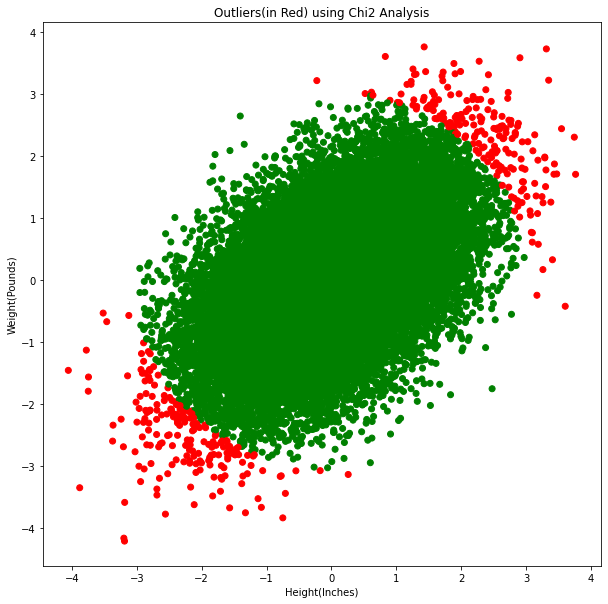

In [32]:
#Plotting outliers using Chi2

plt.figure(figsize=(10, 10))
plt.title("Outliers(in Red) using Chi2 Analysis")
plt.scatter(data_z[:,0], data_z[:,1], c=data_all["Z_agg_Outlier"].map(colors))
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [33]:
# Mahalanobis Distance Analysis as Height and Weight are not independent

# Covariance matrix
cov  = np.cov(X , rowvar=False)

# Covariance matrix power of -1
invcov = np.linalg.matrix_power(cov, -1)

# Mean vector
data_mean = np.mean(X , axis=0).T

# Calculating Mahalanobis Distance
mahal_dist = []
df = data[["Height(Inches)","Weight(Pounds)"]]
for i, row in df.iterrows():
    d = (row.to_numpy()-data_mean).T.dot(invcov).dot(row.to_numpy()-data_mean)
    mahal_dist.append(d)
data_all['Mahal_Dist'] = mahal_dist

data_all['Mahal_Outlier'] = data_all['Mahal_Dist'] > threshold

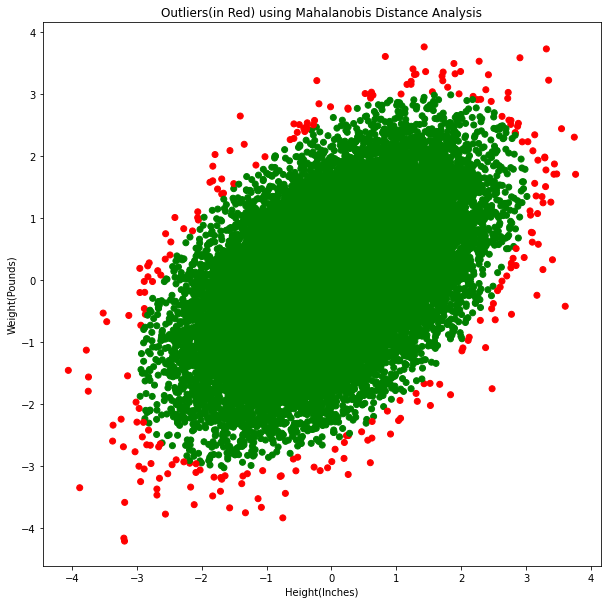

In [34]:
#Plotting outliers using Mahalanobis Distance

plt.figure(figsize=(10, 10))
plt.title("Outliers(in Red) using Mahalanobis Distance Analysis")
plt.scatter(data_z[:,0], data_z[:,1], c=data_all["Mahal_Outlier"].map(colors))
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [35]:
data_all

,Height(Inches),Weight(Pounds),Height_z,Weight_z,Height_z_outlier,Weight_z_outlier,Z_score_outlier,Z_agg,Z_agg_Outlier,Mahal_Dist,Mahal_Outlier
0,65.78331,112.9925,-1.162051,-1.208072,False,False,False,2.809800,False,1.870988,False
1,71.51521,136.4873,1.852136,0.806805,False,False,False,4.081340,False,3.451033,False
2,69.39874,153.0269,0.739165,2.225214,False,False,False,5.497944,False,5.144445,False
3,68.21660,142.3354,0.117523,1.308328,False,False,False,1.725535,False,2.102482,False
4,67.78781,144.2971,-0.107961,1.476561,False,False,False,2.191887,False,3.148188,False
...,...,...,...,...,...,...,...,...,...,...,...
24995,69.50215,118.0312,0.793544,-0.775961,False,False,False,1.231828,False,2.477515,False
24996,64.54826,120.1932,-1.811517,-0.590551,False,False,False,3.630343,False,3.418843,False
24997,64.69855,118.2655,-1.732485,-0.755868,False,False,False,3.572840,False,3.019184,False
24998,67.52918,132.2682,-0.243965,0.444981,False,False,False,0.257527,False,0.490800,False


In [49]:
# Farthest 5 Outliers using Mahalanobis Distance
df = data_all.sort_values("Mahal_Dist", ascending=False).head(5)
df

,Height(Inches),Weight(Pounds),Height_z,Weight_z,Height_z_outlier,Weight_z_outlier,Z_score_outlier,Z_agg,Z_agg_Outlier,Mahal_Dist,Mahal_Outlier
16752,74.84890,122.16640,3.605195,-0.421333,True,False,True,13.174955,True,19.677932,True
22945,61.92639,78.01476,-3.190257,-4.207707,True,True,True,27.882543,True,19.248980,True
14106,61.90725,78.56785,-3.200322,-4.160275,True,True,True,27.549953,True,18.951165,True
23728,72.70475,106.66050,2.477669,-1.751094,False,False,False,9.205175,False,18.160170,True
2651,60.61265,88.04646,-3.881103,-3.347405,True,True,True,26.268078,True,17.669744,True
